# Dataflow with albumentations

In [1]:
# !pip3 install albumentations

In [2]:
from albumentations import Compose, Resize, RandomCropNearBBox, ShiftScaleRotate, GaussNoise, ElasticTransform
from albumentations import RandomBrightnessContrast, Normalize


import cv2
import numpy as np

from image_dataset_viz import render_datapoint

import matplotlib.pylab as plt

%matplotlib inline

In [3]:
import sys

sys.path.insert(0, "../code/deeplab")

In [4]:
from dataflow.dataloaders import get_train_val_loaders
from dataflow.datasets import get_train_dataset
from dataflow.transforms import ToTensor

In [5]:
train_ds = get_train_dataset(root_path="/home/storage_ext4_1tb/")

In [6]:
from PIL import Image

In [7]:
def _getvocpallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0, n):
        lab = j
        pallete[j*3+0] = 0
        pallete[j*3+1] = 0
        pallete[j*3+2] = 0
        i = 0
        while (lab > 0):
            pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
            pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
            pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3
    return pallete

vocpallete = _getvocpallete(256)

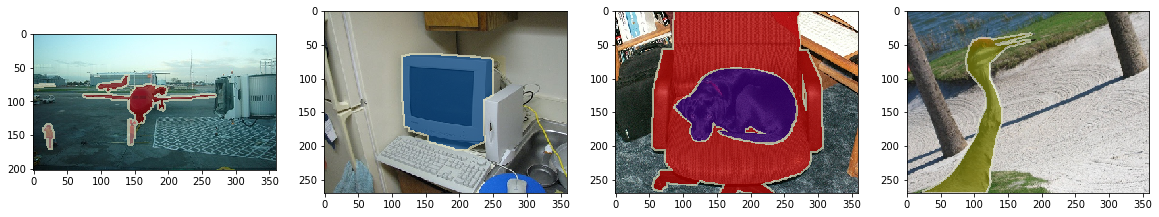

In [8]:
plt.figure(figsize=(20, 5))
for i in range(4):
    dp = train_ds[i]
    plt.subplot(1, 4, i + 1)
    mask = Image.fromarray(dp['mask'])
    mask.putpalette(vocpallete)
    mask = mask.convert(mode='RGB')
    plt.imshow(render_datapoint(dp['image'], mask, output_size=(360, 360)))

In [9]:
dp['image'].shape, dp['image'].dtype

((375, 500, 3), dtype('uint8'))

In [10]:
dp['mask'].shape, dp['mask'].dtype, np.unique(dp['mask'])

((375, 500), dtype('uint8'), array([  0,   3, 255], dtype=uint8))

In [11]:

train_transforms = Compose([
    ShiftScaleRotate(shift_limit=0.2, scale_limit=0.075, rotate_limit=45, interpolation=cv2.INTER_CUBIC, p=0.3),
    Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    GaussNoise(),
    RandomBrightnessContrast(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor(),
])
train_transform_fn = lambda dp: train_transforms(**dp)



val_transforms = Compose([
    Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor(),    
])
val_transform_fn = lambda dp: val_transforms(**dp)


In [13]:
train_loader, val_loader, train_eval_loader = get_train_val_loaders(root_path="/home/storage_ext4_1tb/", 
                                                                    train_transforms=train_transform_fn,
                                                                    val_transforms=val_transform_fn,
                                                                    batch_size=4,
                                                                    random_seed=12)

In [14]:
train_loader_iter = iter(train_loader)
val_loader_iter = iter(val_loader)
train_eval_loader_iter = iter(train_eval_loader)

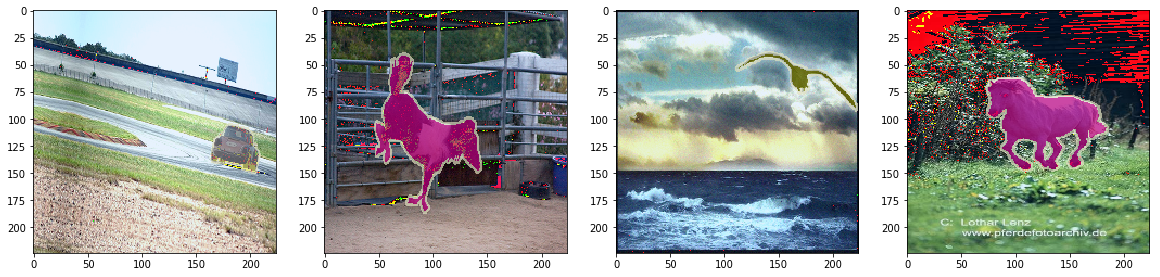

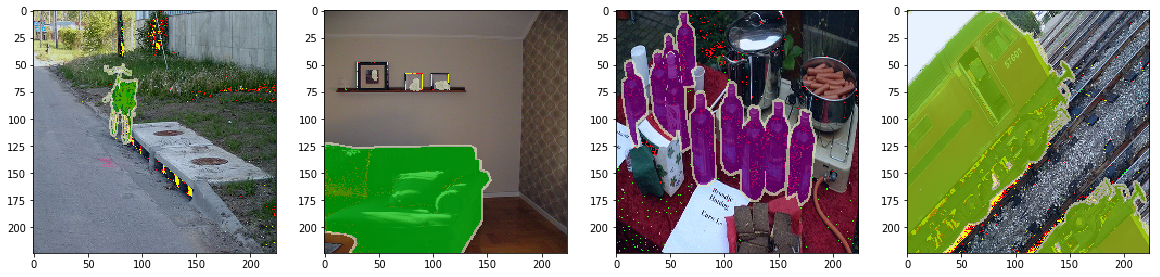

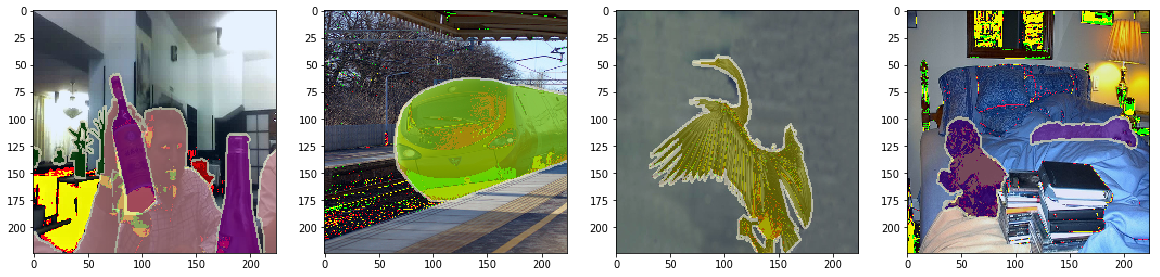

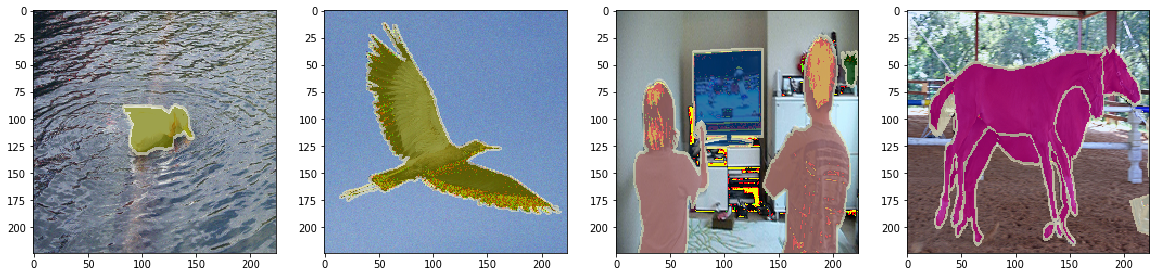

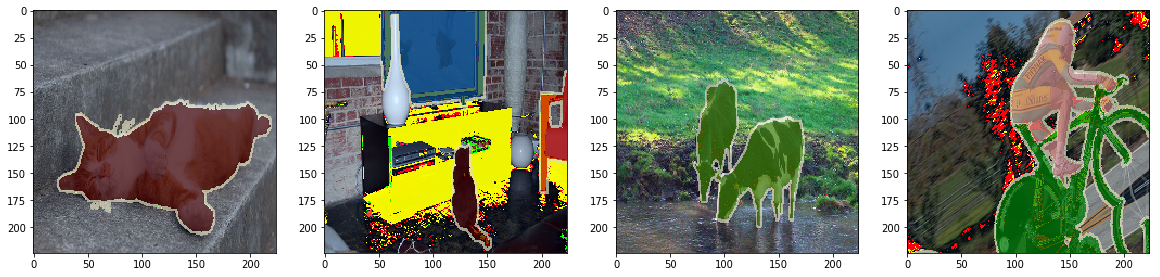

In [16]:
for _ in range(5):
    train_batch = next(train_loader_iter)

    batch_x = train_batch['image']
    batch_y = train_batch['mask']    
    
    plt.figure(figsize=(20, 5))
    for i in range(min(len(batch_x), len(batch_y))):
        img = ((batch_x[i].numpy() * 0.224 + 0.406) * 255).transpose(1, 2, 0).astype(np.uint8)
        mask = batch_y[i].numpy().astype(np.uint8)[0, :, :]
        
        mask = Image.fromarray(mask)
        mask.putpalette(vocpallete)
        mask = mask.convert(mode='RGB')
        
        plt.subplot(1, 4, i + 1)
        plt.imshow(render_datapoint(img, mask, output_size=(360, 360)))